In [ ]:
from google.colab import drive
drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/lol_dataset/our485"

low_path = os.path.join(dataset_path, "low")
high_path = os.path.join(dataset_path, "high")

print("Low-light images:", len(os.listdir(low_path)))
print("Ground truth images:", len(os.listdir(high_path)))


Low-light images: 485
Ground truth images: 485


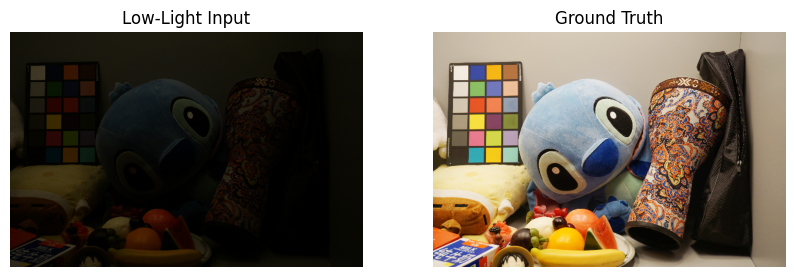

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random

def show_pair():
    img_name = random.choice(os.listdir(low_path))

    low_img = cv2.imread(os.path.join(low_path, img_name))
    high_img = cv2.imread(os.path.join(high_path, img_name))

    low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
    high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(low_img)
    plt.title("Low-Light Input")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(high_img)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.show()

show_pair()


In [ ]:
!pip install scikit-image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [ ]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    return enhanced


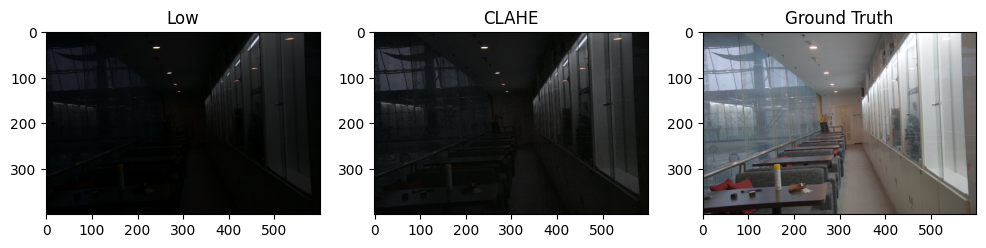

In [ ]:
img_name = random.choice(os.listdir(low_path))

low_img = cv2.imread(os.path.join(low_path, img_name))
gt_img = cv2.imread(os.path.join(high_path, img_name))

low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

enhanced = apply_clahe(low_img)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(low_img)
plt.title("Low")

plt.subplot(1,3,2)
plt.imshow(enhanced)
plt.title("CLAHE")

plt.subplot(1,3,3)
plt.imshow(gt_img)
plt.title("Ground Truth")

plt.show()


In [ ]:
psnr_value = psnr(gt_img, enhanced, data_range=255)
ssim_value = ssim(gt_img, enhanced, channel_axis=2, data_range=255)

print("PSNR:", psnr_value)
print("SSIM:", ssim_value)


PSNR: 8.13262554429542
SSIM: 0.2105815783642603


In [ ]:
scores = []

sample_images = os.listdir(low_path)[:100]

for img_name in sample_images:

    low = cv2.imread(os.path.join(low_path, img_name))
    gt = cv2.imread(os.path.join(high_path, img_name))

    low = cv2.cvtColor(low, cv2.COLOR_BGR2RGB)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    enhanced = apply_clahe(low)

    p = psnr(gt, enhanced, data_range=255)
    s = ssim(gt, enhanced, channel_axis=2, data_range=255)

    scores.append((p, s))

avg_psnr = np.mean([x[0] for x in scores])
avg_ssim = np.mean([x[1] for x in scores])

print("Average PSNR:", avg_psnr)
print("Average SSIM:", avg_ssim)


Average PSNR: 8.196934436278365
Average SSIM: 0.31630285987117746


In [ ]:
import numpy as np

def gamma_correction(img, gamma=1.5):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255
                      for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

gamma_img = gamma_correction(low_img, gamma=2.0)

psnr_gamma = psnr(gt_img, gamma_img, data_range=255)
ssim_gamma = ssim(gt_img, gamma_img, channel_axis=2, data_range=255)

print("Gamma PSNR:", psnr_gamma)
print("Gamma SSIM:", ssim_gamma)


Gamma PSNR: 10.319276575724942
Gamma SSIM: 0.4587938641025448


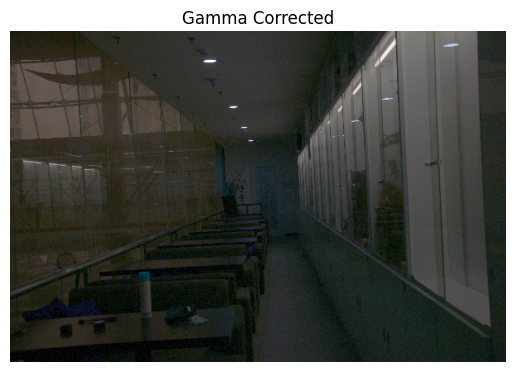

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Save the image for LaTeX
cv2.imwrite('figures/gamma.png', gamma_img)

# Display it
plt.imshow(cv2.cvtColor(gamma_img, cv2.COLOR_BGR2RGB))
plt.title("Gamma Corrected")
plt.axis('off')
plt.show()


In [ ]:
denoised = cv2.fastNlMeansDenoisingColored(
    low_img, None,
    h=10, hColor=10,
    templateWindowSize=7,
    searchWindowSize=21
)

psnr_denoise = psnr(gt_img, denoised, data_range=255)
ssim_denoise = ssim(gt_img, denoised, channel_axis=2, data_range=255)

print("Denoise PSNR:", psnr_denoise)
print("Denoise SSIM:", ssim_denoise)


Denoise PSNR: 6.851201520543225
Denoise SSIM: 0.09931076794643383


In [ ]:
!pip install brisque
!pip install libsvm-official


In [ ]:
from brisque import BRISQUE

# Initialize BRISQUE model
brisque = BRISQUE()

def compute_brisque(img):
    # img should be BGR for the BRISQUE library
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return brisque.score(img_bgr)

print("Baseline BRISQUE:", compute_brisque(low_img))
print("CLAHE BRISQUE:", compute_brisque(enhanced))
print("Gamma BRISQUE:", compute_brisque(gamma_img))
print("Denoise BRISQUE:", compute_brisque(denoised))


Baseline BRISQUE: 22.25114277973873
CLAHE BRISQUE: 13.455392559065075
Gamma BRISQUE: 24.110698690252292
Denoise BRISQUE: 86.34808257418476


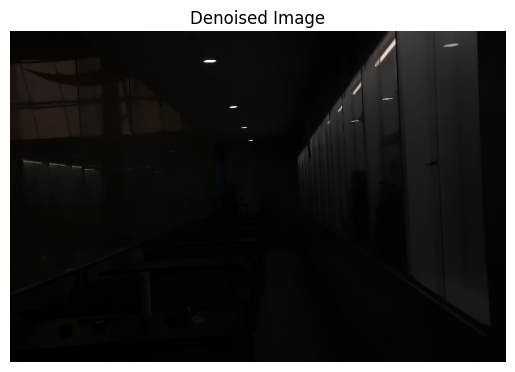

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Save for LaTeX
cv2.imwrite('figures/denoised.png', denoised)

# Display it
plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
plt.title("Denoised Image")
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd

# Define methods to test
methods = {
    "Original": lambda x: x,
    "CLAHE": apply_clahe,
    "Gamma (2.0)": lambda x: gamma_correction(x, gamma=2.0),
    "Denoise": lambda x: cv2.fastNlMeansDenoisingColored(x, None, 10, 10, 7, 21)
}

results = []
sample_names = os.listdir(low_path)[:100]

print("Running comparative evaluation...")

for img_name in sample_names:
    low = cv2.cvtColor(cv2.imread(os.path.join(low_path, img_name)), cv2.COLOR_BGR2RGB)
    gt = cv2.cvtColor(cv2.imread(os.path.join(high_path, img_name)), cv2.COLOR_BGR2RGB)

    for name, func in methods.items():
        enhanced = func(low)

        # Calculate metrics
        p = psnr(gt, enhanced, data_range=255)
        s = ssim(gt, enhanced, channel_axis=2, data_range=255)
        b = compute_brisque(enhanced)

        results.append({"Method": name, "PSNR": p, "SSIM": s, "BRISQUE": b})

# Aggregate into Table 2 for your paper
df_results = pd.DataFrame(results)
summary_table = df_results.groupby("Method").mean().reset_index()
print("\n--- Final Table 2: Quantitative Metrics ---")
print(summary_table.to_string(index=False))

Running comparative evaluation...

--- Final Table 2: Quantitative Metrics ---
     Method      PSNR     SSIM   BRISQUE
      CLAHE  8.196934 0.316303 27.696759
    Denoise  7.000079 0.148608 93.094636
Gamma (2.0) 10.560800 0.473939 22.857857
   Original  7.048369 0.163084 28.692570


FileNotFoundError: [Errno 2] No such file or directory: 'figures/final_comparison.png'

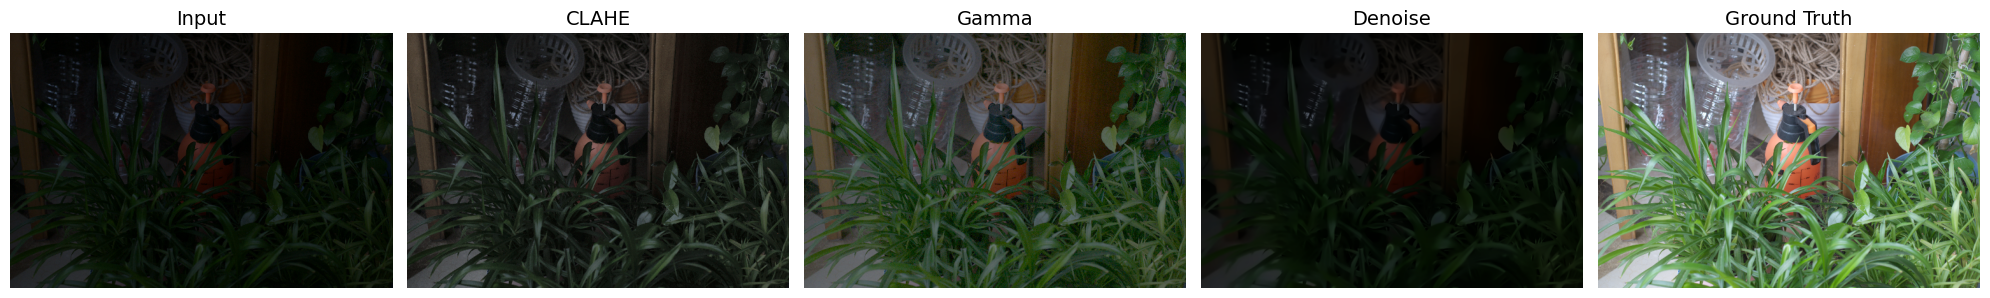

In [ ]:
def generate_comparison_figure(img_index=0):
    img_name = os.listdir(low_path)[img_index]
    low = cv2.cvtColor(cv2.imread(os.path.join(low_path, img_name)), cv2.COLOR_BGR2RGB)
    gt = cv2.cvtColor(cv2.imread(os.path.join(high_path, img_name)), cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    titles = ["Input", "CLAHE", "Gamma", "Denoise", "Ground Truth"]
    imgs = [low, apply_clahe(low), gamma_correction(low, 2.0),
            cv2.fastNlMeansDenoisingColored(low, None, 10, 10, 7, 21), gt]

    for ax, img, title in zip(axes, imgs, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig("figures/final_comparison.png", dpi=300)
    plt.show()

generate_comparison_figure(72) # Pick a visually interesting index

In [ ]:
# 1. Separate images into 'Very Dark' and 'Moderate Low Light'
very_dark_scores = []
moderate_dark_scores = []

for img_name in sample_images:
    low = cv2.cvtColor(cv2.imread(os.path.join(low_path, img_name)), cv2.COLOR_BGR2RGB)
    gt = cv2.cvtColor(cv2.imread(os.path.join(high_path, img_name)), cv2.COLOR_BGR2RGB)

    mean_brightness = np.mean(low)

    # Run Gamma and CLAHE
    g_img = gamma_correction(low, 2.0)
    c_img = apply_clahe(low)

    g_ssim = ssim(gt, g_img, channel_axis=2, data_range=255)
    c_ssim = ssim(gt, c_img, channel_axis=2, data_range=255)

    data = {"brightness": mean_brightness, "Gamma_SSIM": g_ssim, "CLAHE_SSIM": c_ssim}

    if mean_brightness < 20: # Example threshold
        very_dark_scores.append(data)
    else:
        moderate_dark_scores.append(data)

# 2. Compare the averages
print(f"Very Dark (<20) -> Gamma: {np.mean([x['Gamma_SSIM'] for x in very_dark_scores]):.3f}, CLAHE: {np.mean([x['CLAHE_SSIM'] for x in very_dark_scores]):.3f}")
print(f"Moderate (>20) -> Gamma: {np.mean([x['Gamma_SSIM'] for x in moderate_dark_scores]):.3f}, CLAHE: {np.mean([x['CLAHE_SSIM'] for x in moderate_dark_scores]):.3f}")

Very Dark (<20) -> Gamma: 0.405, CLAHE: 0.256
Moderate (>20) -> Gamma: 0.750, CLAHE: 0.556
